## The git code

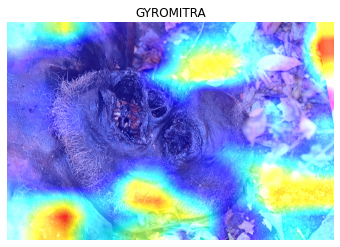

In [34]:
from keras.applications.vgg16 import decode_predictions
import numpy as np
import pandas as pd

def cam(img_path):
    from keras.applications.vgg16 import VGG16
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    %matplotlib inline
    K.clear_session()
    
    model = VGG16(weights='imagenet')
    #model.summary()
    img=mpimg.imread(img_path)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],
                               columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = '/data/zyang/Test_dataset/tmp_samples/2b701108.19_cam.JPG'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None
cam('/data/zyang/Test_dataset/tmp_samples/2b701108.19.JPG')

## My VGG-based CAM

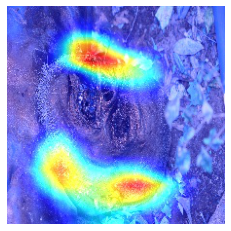

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.image as mpimg
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import cv2

%matplotlib inline
K.clear_session()


def cam(img_path):
    model_name = 'vgg_10000_epoch_-026-_acc_0.997706-_val_acc_0.97035.h5'#'inception_epoch_-044-_acc_0.995226-_val_acc_0.96135.h5'
    model = load_model(model_name)
    img=mpimg.imread(img_path)
    plt.imshow(img)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    #predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],
                               #columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    #img = cv2.imread(img_path)
    #heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.resize(heatmap, (img.size[1], img.size[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = img_path.replace('.JPG', 'cam.JPG')
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    #plt.title(predictions.loc[0,'category'].upper())
    return x, heatmap

img, hm = cam('/data/zyang/Test_dataset/tmp_samples/2b701108.19.JPG')

In [5]:
hm.shape

(4000, 6000, 3)

(array([[[[-0.81960785, -0.81960785, -0.81960785],
          [-0.70980394, -0.67058825, -0.7019608 ],
          [-0.5137255 , -0.54509807, -0.6156863 ],
          ...,
          [-0.49019605, -0.45098037, -0.4980392 ],
          [-0.67058825, -0.6313726 , -0.6627451 ],
          [-0.84313726, -0.8509804 , -0.88235295]],
 
         [[-0.85882354, -0.8901961 , -0.8980392 ],
          [-0.73333335, -0.7411765 , -0.77254903],
          [-0.58431375, -0.5921569 , -0.6313726 ],
          ...,
          [-0.54509807, -0.5137255 , -0.5058824 ],
          [-0.7490196 , -0.7411765 , -0.78039217],
          [-0.8666667 , -0.8509804 , -0.8745098 ]],
 
         [[-0.7647059 , -0.7882353 , -0.827451  ],
          [-0.7882353 , -0.79607844, -0.8352941 ],
          [-0.6       , -0.5921569 , -0.6313726 ],
          ...,
          [-0.62352943, -0.5764706 , -0.5921569 ],
          [-0.8509804 , -0.8352941 , -0.8745098 ],
          [-0.84313726, -0.8352941 , -0.8745098 ]],
 
         ...,
 
         [[-

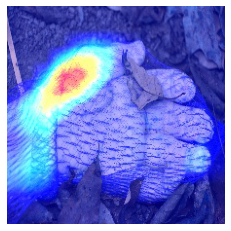

In [8]:
cam('/data/zyang/Test_dataset/tmp_samples/fb501105.28.JPG')

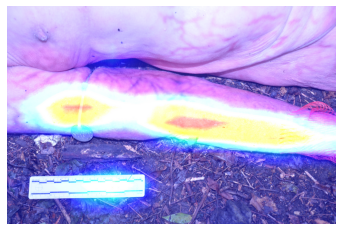

In [37]:
cam('/data/zyang/Test_dataset/tmp_samples/96000707.11.JPG')

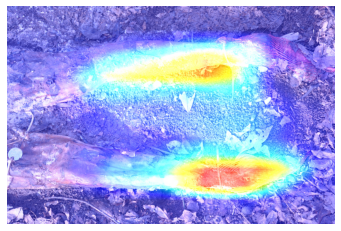

In [38]:
cam('/data/zyang/Test_dataset/tmp_samples/95210126.16.JPG')

## My Inception_based CAM

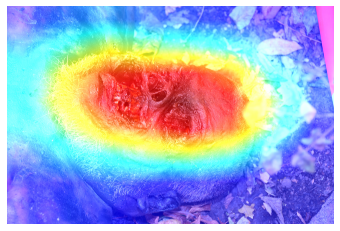

In [39]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.image as mpimg
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import cv2

%matplotlib inline
K.clear_session()


def cam(img_path):
    model_name ='inception_epoch_-044-_acc_0.995226-_val_acc_0.96135.h5'
    model = load_model(model_name)
    #model.summary()
    img=mpimg.imread(img_path)
    plt.imshow(img)
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('mixed10')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = img_path.replace('.JPG', 'cam.JPG')
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    return None

cam('/data/zyang/Test_dataset/tmp_samples/2b701108.19.JPG')

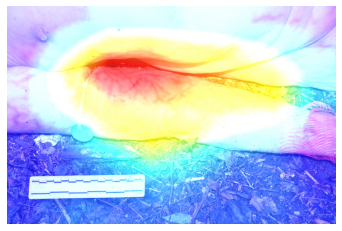

In [40]:
cam('/data/zyang/Test_dataset/tmp_samples/96000707.11.JPG')

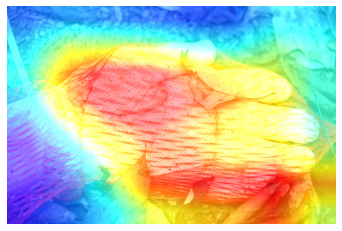

In [41]:
cam('/data/zyang/Test_dataset/tmp_samples/fb501105.28.JPG')

(-0.5, 5999.5, 3999.5, -0.5)

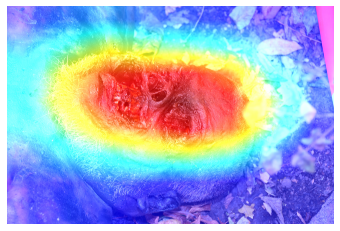

In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.image as mpimg
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import cv2

%matplotlib inline
K.clear_session()

img_path = '/data/zyang/Test_dataset/tmp_samples/2b701108.19.JPG' 
model_name ='inception_epoch_-044-_acc_0.995226-_val_acc_0.96135.h5'
model = load_model(model_name)
#model.summary()
img=mpimg.imread(img_path)
plt.imshow(img)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
last_conv_layer = model.get_layer('mixed10')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = .8
superimposed_img = heatmap * hif + img
output = img_path.replace('.JPG', 'cam.JPG')
cv2.imwrite(output, superimposed_img)
img=mpimg.imread(output)
plt.imshow(img)
plt.axis('off')


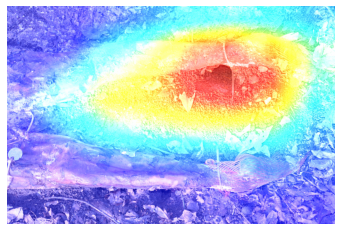

In [33]:
cam('/data/zyang/Test_dataset/tmp_samples/95210126.16.JPG')